In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from glob import glob
from hmmlearn import hmm
import librosa
import librosa.display

In [2]:
TOP_DB = 40
MFCC_SIZE = 39
TEST_SIZE = 0.2

## Read file

In [3]:
audio_files = sorted(glob('./recordings/*'))

In [4]:
import re

text = audio_files[300]
pattern = r'(\d+)_([a-zA-Z]+)_(\d+)\.wav'

result = re.search(pattern, text)
groups = result.groups()
dictionary = {
    'number': int(groups[0]),
    'name': groups[1],
    'order': int(groups[2])
}
dictionary

{'number': 1, 'name': 'george', 'order': 0}

In [5]:
def convert_path_to_dict(path):
    pattern = r'(\d+)_([a-zA-Z]+)_(\d+)\.wav'

    result = re.search(pattern, path)
    groups = result.groups()
    return {
        'number': int(groups[0]),
        'name': groups[1],
        'order': int(groups[2])
    }
convert_path_to_dict(audio_files[300])

{'number': 1, 'name': 'george', 'order': 0}

## MFCC

In [6]:
def analyse_audio(path):
    output = convert_path_to_dict(path)
    y, sr = librosa.load(path)
    y_tr, index = librosa.effects.trim(y, top_db=TOP_DB)
    mfcc = np.array(librosa.feature.mfcc(y=y_tr, sr=sr, n_mfcc=13))
    output['sr'] = sr
    output['y'] = y
    output['y trim'] = y_tr
    # ? we use transfer mfcc
    output['mfcc'] = mfcc.T
    return output
print([len(i) for i in analyse_audio(audio_files[0])['mfcc']])
print([len(i) for i in analyse_audio(audio_files[1])['mfcc']])
print([len(i) for i in analyse_audio(audio_files[2])['mfcc']])

[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]


In [7]:
output_list = [analyse_audio(file) for file in audio_files]
df = pd.DataFrame(output_list)
df[:3]

,number,name,order,sr,y,y trim,mfcc
0,0,george,0,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-633.7214, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,0,george,1,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-643.057, 25.02723, 23.553139, 21.222677, 18..."
2,0,george,10,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-638.5822, -0.03040633, -19.927683, -0.31883..."


Text(0.5, 1.0, 'MFCC')

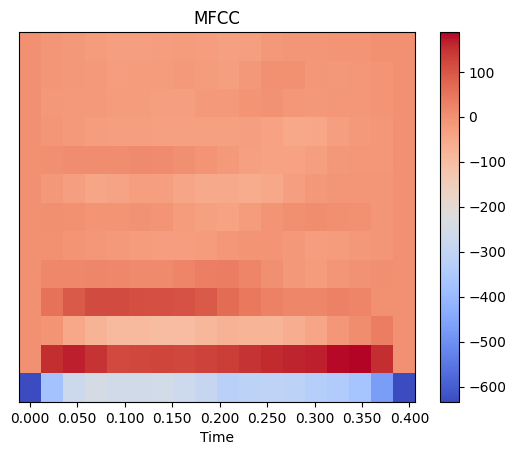

In [8]:
img = librosa.display.specshow(df['mfcc'][0].T, x_axis='time')
plt.colorbar(img)
plt.title('MFCC')

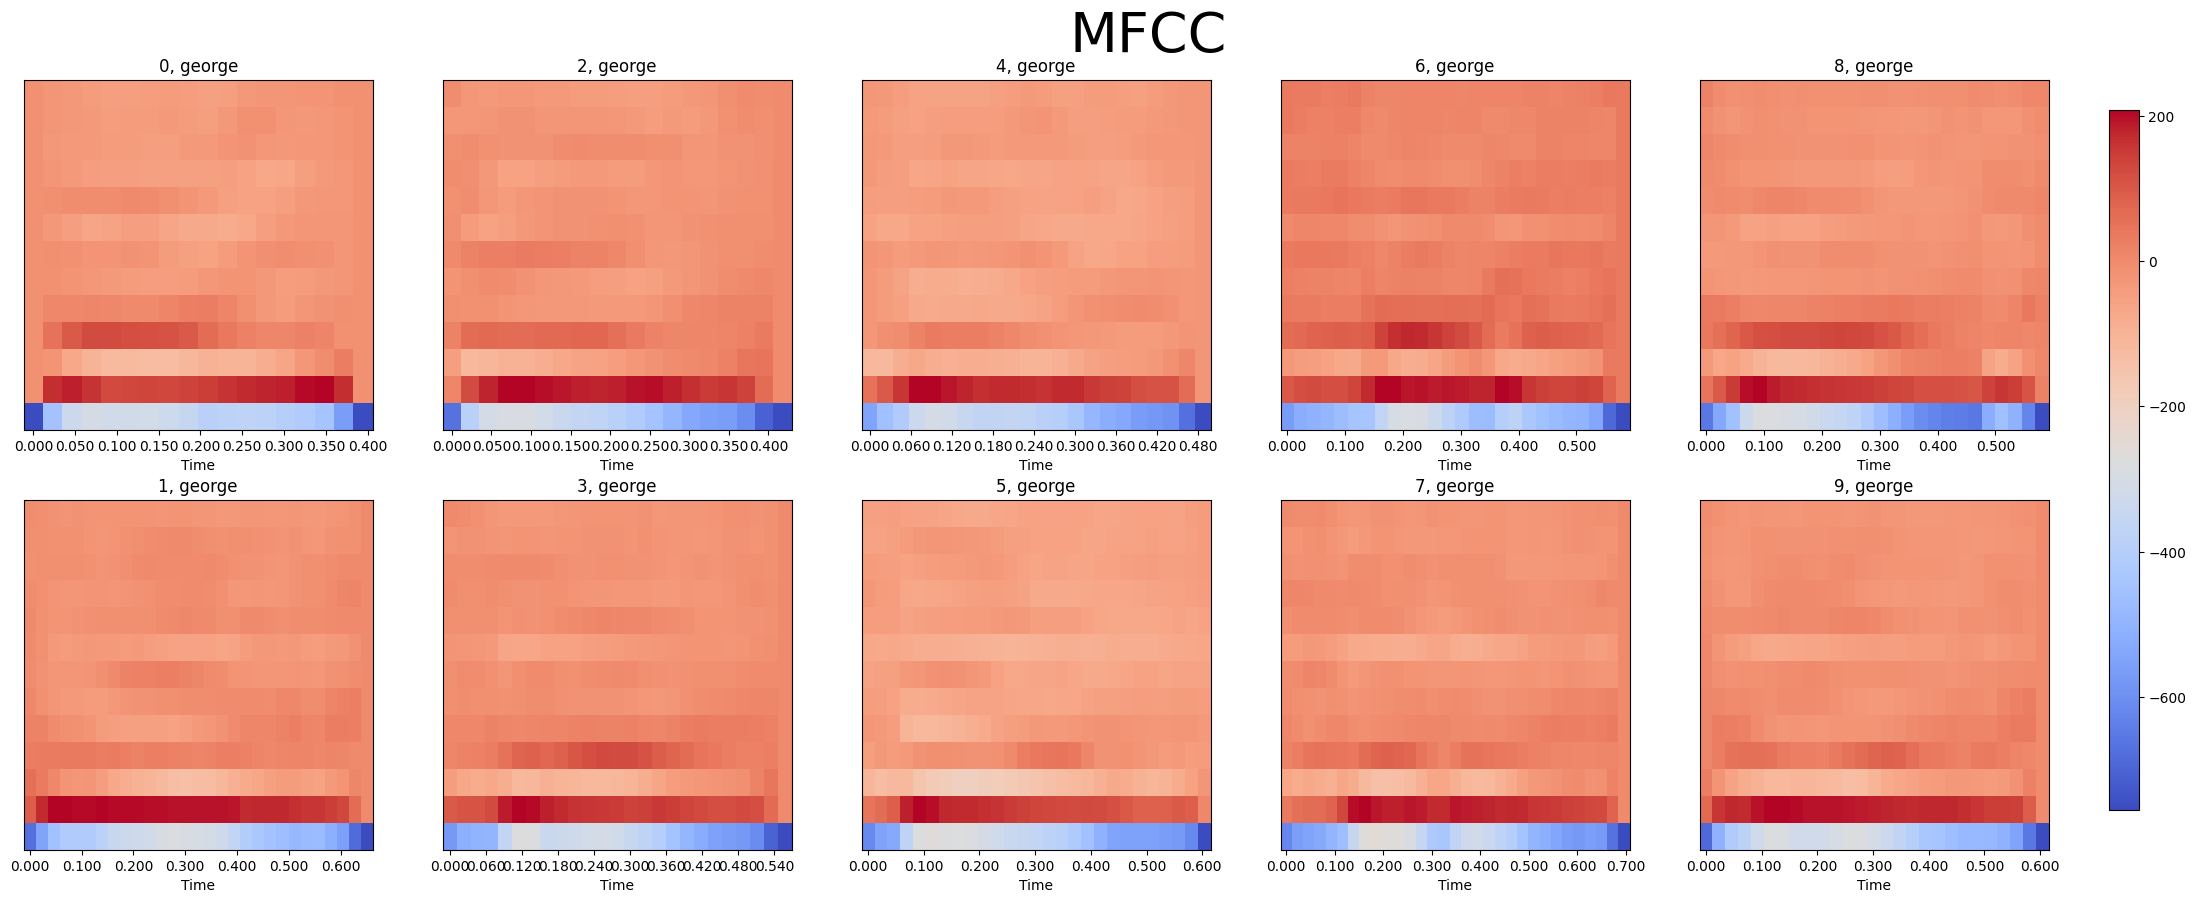

In [9]:
fig, axs = plt.subplots(2, 5, figsize=(30,10))
img=None
for i in range(10):
    img = librosa.display.specshow(df[df['number'] == i]['mfcc'].iloc[0].T, x_axis='time',ax=axs[i%2,i//2])
    axs[i%2,i//2].set_title(f"{i}, {df[df['number'] == i]['name'].iloc[0]}")
fig.suptitle('MFCC',y=0.95,fontsize=40)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7])
fig.colorbar(img, cax=cbar_ax)

## Create hmm

In [10]:
def create_test_and_train_data(df, par_main, par_side, test_percent=TEST_SIZE):
    '''[par_main][par_side] = mfcc'''
    training_data = dict()
    testing_data = dict()
    for i in df[par_main].unique():
        train_tmp = []
        test_tmp = []
        for j in df[par_side].unique():
            filtered_data = np.array(df[(df[par_main] == i) & (df[par_side] == j)]['mfcc'])
            test_size = int(len(filtered_data) * test_percent)
            train_tmp.append(filtered_data[:-test_size])
            test_tmp.append(filtered_data[-test_size:])
        training_data[i] = np.concatenate(train_tmp)
        testing_data[i] = np.concatenate(test_tmp)
    return training_data, testing_data

In [11]:
def train_data(data:dict, n_com=3) -> dict:
    hmms = dict()
    for num in data.keys():
        data_len = [len(i) for i in data[num]]
        concatenate_data = np.concatenate(np.array(data[num]))
        new_hmm = hmm.GaussianHMM(n_components=n_com, covariance_type='diag', n_iter=1000)
        new_hmm.fit(concatenate_data, lengths=data_len)
        hmms[num] = new_hmm
    return hmms

In [12]:
def test_hmm(data:dict, hmms:dict) -> dict:
    result = dict()
    for i in data.keys():
        result[i] = []
        for j in data[i]:
            tmp = dict()
            for k in hmms.keys():
                tmp[k] = hmms[k].score(j)
            q = max(tmp, key=lambda k: tmp[k])
            result[i].append(q)
    return result

In [13]:
def draw_confusion(confusion_df):
    ax = sns.heatmap(confusion_df, annot=True, linewidth=0.5, fmt='0')
    ax.set(xlabel="label", ylabel="result")
    ax.invert_yaxis()

In [14]:
def calculate_confusion(result):
    result_matrix = {i:
        {j:
            result[i].count(j)
            for j in result.keys()} 
        for i in result.keys()}
    return pd.DataFrame(result_matrix)

In [15]:
def convert_confusion_to_T_F_P_N(confusion_df):
    confusion_matrix = confusion_df.to_numpy()
    m = {list(result.keys())[i]:
        {
            'TP': confusion_matrix[i,i],
            'FP': np.sum(confusion_matrix[i,:]) - confusion_matrix[i,i],
            'FN': np.sum(confusion_matrix[:,i]) - confusion_matrix[i,i]
        }
        for i in range(len(list(result.keys())))}
    return pd.DataFrame(m).transpose()

In [16]:
def calculate_score(T_F_P_N_df, confusion_df):
    precision = T_F_P_N_df['TP'] / (T_F_P_N_df['TP'] + T_F_P_N_df['FP'])
    recall = T_F_P_N_df['TP'] / (T_F_P_N_df['TP'] + T_F_P_N_df['FN'])
    f1 = 2 * precision * recall / (precision + recall)
    return pd.DataFrame({'f1': f1, 'precision': precision, 'recall': recall})

In [17]:
def calculate_micro_macro(df, confusion_df):
    confusion_matrix = confusion_df.to_numpy()
    accuracy = np.sum(np.diagonal(confusion_matrix)) / np.sum(confusion_matrix)
    
    out = {'macro':{
        'accuracy': accuracy,
        'precision': np.mean(df['precision']),
        'recall': np.mean(df['recall'])
    },
     'micro':{
        'accuracy': accuracy,
        'precision': np.sum(df['TP']) / (np.sum(df['TP']) + np.sum(df['FP'])),
        'recall': np.sum(df['TP']) / (np.sum(df['TP']) + np.sum(df['FN']))
    }}
    
    for i in out.keys():
        out[i]['f1'] = 2 * out[i]['precision'] * out[i]['recall'] / (out[i]['precision'] + out[i]['recall'])
    return pd.DataFrame(out).transpose()

In [18]:
def analyse_result(result):
    confusion_df = calculate_confusion(result)
    draw_confusion(confusion_df)
    T_F_P_N_df = convert_confusion_to_T_F_P_N(confusion_df)
    score_df = calculate_score(T_F_P_N_df, confusion_df)
    df = pd.concat([T_F_P_N_df, score_df], axis=1)
    total_df = calculate_micro_macro(df, confusion_df)
    display(df)
    display(total_df)

## Test

,TP,FP,FN,f1,precision,recall
0,57,2,3,0.957983,0.966102,0.950000
1,60,4,0,0.967742,0.937500,1.000000
2,55,2,5,0.940171,0.964912,0.916667
3,59,8,1,0.929134,0.880597,0.983333
4,60,0,0,1.000000,1.000000,1.000000
5,56,0,4,0.965517,1.000000,0.933333
6,56,1,4,0.957265,0.982456,0.933333
7,58,1,2,0.974790,0.983051,0.966667
8,59,2,1,0.975207,0.967213,0.983333
9,60,0,0,1.000000,1.000000,1.000000


,accuracy,precision,recall,f1
macro,0.966667,0.968183,0.966667,0.967424
micro,0.966667,0.966667,0.966667,0.966667


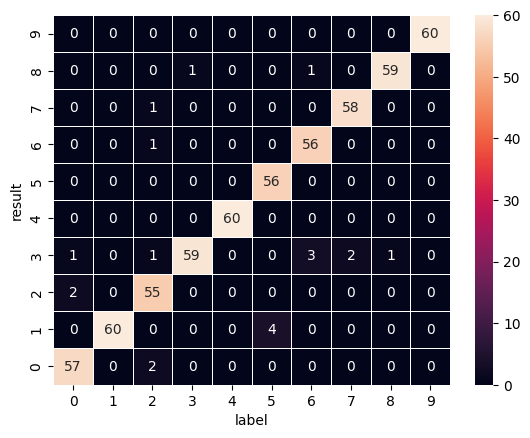

In [19]:
training_data, testing_data = create_test_and_train_data(df, 'number', 'name')
hmms = train_data(training_data, n_com=10)
result = test_hmm(testing_data, hmms)
analyse_result(result)

,TP,FP,FN,f1,precision,recall
george,100,0,0,1.000000,1.000000,1.00
jackson,100,0,0,1.000000,1.000000,1.00
lucas,100,0,0,1.000000,1.000000,1.00
nicolas,100,0,0,1.000000,1.000000,1.00
theo,96,2,4,0.969697,0.979592,0.96
yweweler,98,4,2,0.970297,0.960784,0.98


,accuracy,precision,recall,f1
macro,0.99,0.990063,0.99,0.990031
micro,0.99,0.990000,0.99,0.990000


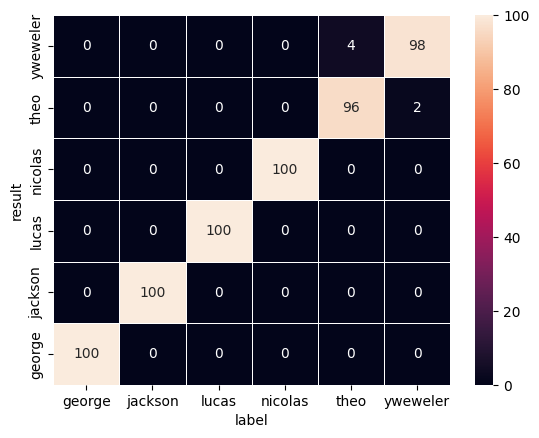

In [20]:
training_data, testing_data = create_test_and_train_data(df, 'name', 'number')
hmms = train_data(training_data, n_com=10)
result = test_hmm(testing_data, hmms)
analyse_result(result)